# Sprint 3

During the course we learned how to approach machine learning problems, we gained intuition and used multiple different algorithms. 

In the third and final sprint we decided to use these building to try and create a machine learning model end-to-end. We decided to put a lot of our focus on how the solution we would create could actually be used. Creating models in Jupyter notebook thought us how to experiment with machine learning models. But now we decided to go beyond the course so that we would learn how the models we learned to create could actually be used by users.

This meant that during Sprint 3 we would need to do the following things:
* Define a problem to solve.
* Find a way to solve our problem.
* Make our solution available for actual users.

> **note**: Since we are using multiple cloud tools througout the notebook we recommend uploading this file to a google colab notebook.

>**note**: Some command executions require authentication. These will throw errors, however we put them in the notebook for documentation purposes.

In [1]:
!pip install gcsfs
!conda install --yes --prefix {sys.prefix} nltk bs4 gensim

import sys
import os 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

import multiprocessing
from gensim.sklearn_api import D2VTransformer

from sklearn.model_selection import train_test_split


# %tensorflow_version 1.x
# import tensorflow as tf
# import tensorflow_hub as hub
# import shutil

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import CategoricalCrossentropy


EnvironmentLocationNotFound: Not a conda environment: /home/jovyan/data/{sys.prefix}



[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Defining a problem to solve

### Idea 1

The following section will describe the first idea we had and the steps we took to find out that the data was not what we expected it to be. 

**Idea 1**: Can we predict the quality (Consumer disputed?)  of an answer (Company response to consumer + Timely response) based upon the customers’ messages (Consumer complaint narrative) and the context (Product + Issue)?

#### Reading the data

Our data is stored in Google Cloud Storage within the Google Cloud Platform. This requires some initial setup.

In [2]:
PROJECT = 'appliedml-270208'
BUCKET = 'applied_machine_learning_bucket'
REGION = 'europe-west1'

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION

!gcloud config set project $PROJECT
!gcloud config set compute/region $REGION

/bin/sh: 1: gcloud: not found
/bin/sh: 1: gcloud: not found


Lets read the data:

In [3]:
raw_data = pd.read_csv('gs://'+BUCKET+'/complaints-2020-01-22_08_24.csv')
#raw_data = pd.read_csv('complaints-2020-01-22_08_24.csv')

#### Selecting columns

The selection of the columns was based upon our knowledge gained from the EDA phases in previous sprints.

In [4]:
relevant_data = raw_data[[
    'Consumer complaint narrative', 
    'Company public response',
    'Company response to consumer',
    'Timely response?', 
    'Consumer disputed?', 
    'Product', 
    'Issue']]

#relevant_data.head()

As seen below the Company response to consumer column is a categorical column. We found this out by doing EDA. We were expecting a text values similar to the Consumer complaint narrative column.

In [5]:
relevant_data['Company response to consumer'].unique()

array(['Closed with explanation', 'Closed with non-monetary relief',
       'Closed with monetary relief', 'Untimely response', 'Closed',
       'In progress', 'None'], dtype=object)

Since the data was not what we expected we decided to come up with a new idea. We are aware we could have used this feature as a categorical column and tried to solve the problem. However, we decided to pivot to a new idea.

### Final Idea

The following section will describe the final idea we decided upon to solve. 

**Idea**: Can we predict the type of issue (Issue) upon the message (Consumer complaint narrative) sent to the company (Company) and the relevant product (Product)? 

## Finding a way to solve our problem

Now that our problem (classification) was defined we experimented with different approaches to solve this problem.

### Distribution analysis of issues

Since we started from a new idea instead of optimizing a previously made solution, we needed a bit more exploratory data analysis.

161


Text(0.5, 1.0, 'issues')

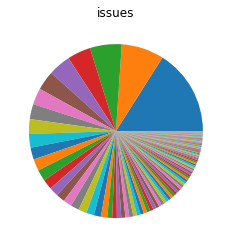

In [6]:
print(len(raw_data['Issue'].unique()))

issues = raw_data["Issue"].value_counts()
patches = plt.pie(issues.values)
plt.title("issues")

We can see that the issue occurance is not balanced at all. This suggested to us that we would need to balance our training data.

We can see that we have 161 classes that are very skewed. Since we have a lot of classes with few to almost no records we decide to work with a cutoff. Issues that have less records than the cutoff value will be grouped together in the ‘Unknown’ class.

### Transform the data

In [7]:
KEEP_LOWER_BOUDNARY = 2000

def define_keeps(df):
    counts = df['Issue'].value_counts()
    names = df['Issue'].value_counts().index
    keep = [ names[i] for i, issue_count in enumerate(counts) if issue_count > KEEP_LOWER_BOUDNARY ]

    return keep

KEEPS = define_keeps(raw_data)

# def make_unknown(row):
#     if not row['Issue'] in KEEPS:
#         row['Issue'] = 'Unknown'
#     return row

# cutoff_data = raw_data.apply(make_unknown, axis=1)

cutoff_data = raw_data.copy()
cutoff_data.loc[~cutoff_data['Issue'].isin(KEEPS), 'Issue'] = "Unknown"

In [8]:
print(f'Issues that are kept: {cutoff_data.loc[cutoff_data["Issue"].isin(KEEPS),:].shape}')
print(f'Issues that are moved to Unknown: {cutoff_data.loc[~cutoff_data["Issue"].isin(KEEPS),:].shape}')

Issues that are kept: (437347, 18)
Issues that are moved to Unknown: (48354, 18)


We prefer not to have whitespace in the feature names. That’s why we executed the following code:

In [9]:
cutoff_data['Message'] = cutoff_data['Consumer complaint narrative']

### Cleaning the data

We decided to clean our data since this would improve results.

In [10]:
stopWords = stopWords = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")
  
def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator).lower()
    text = re.sub(r'(x)\1+', '', text)
    text = re.sub(r'[0-9]', r' ', text)
    tokens = []
    for word in text.split():
        word = stemmer.stem(word)
        if word not in stopWords:
            tokens.append(word)
    return " ".join(tokens)

In [11]:
cleaned_data = cutoff_data.copy()
cleaned_data['Message'] = cleaned_data['Message'].apply(preprocessing)

### Defining constants

At this point, the data has the desired shape. This lets us define constants that we can use throughout the notebook.

In [12]:
CSV_COLUMNS = ['Product', 'Company', 'Message', 'Issue']
CSV_FEATURES = ['Product', 'Company', 'Message']
TARGET_LABEL = 'Issue'
DEFAULTS = [['Unknown'], ['Unknown'], ['Unknown']]

PROD_VOCAB = np.append(cleaned_data['Product'].unique(), 'Unknown')
COMP_VOCAB = np.append(cleaned_data['Company'].unique(), 'Unknown')
ISS_VOCAB = cleaned_data['Issue'].unique()

### Selecting relevant columns

There is no need to hold on to irrelevant columns.

In [13]:
selected_data = cleaned_data[CSV_COLUMNS]
selected_data.head()

,Product,Company,Message,Issue
0,"Credit reporting, credit repair services, or o...",Experian Information Solutions Inc.,complain mani time credit report experian inac...,Credit monitoring or identity theft protection...
1,Debt collection,"Ideal Collection Services, Inc.",pleas review current fraud account also fraudu...,False statements or representation
2,Debt collection,"ONEMAIN FINANCIAL HOLDINGS, LLC.",call multipl time year debt occur dure previou...,Attempts to collect debt not owed
3,Debt collection,"Diversified Consultants, Inc.",sent letter compani valid debt special ask att...,Attempts to collect debt not owed
4,"Credit reporting, credit repair services, or o...","ClearOne Advantage, LLC",appli debt relief product account execut name ...,Improper use of your report


### Train-Eval-Test split

We divided our data into three parts: training data (80%), evaluation data (10%) and testing data (10%). 

In [14]:
x_train, x_test, y_train, y_test = train_test_split(selected_data[CSV_FEATURES], selected_data[TARGET_LABEL], test_size=0.2)
x_eval, x_test, y_eval, y_test  = train_test_split(x_test, y_test, test_size=0.5)

We reassemble the dataframes since they might be necessary at a later point. 

In [15]:
train_data = x_train.copy(deep=True)
train_data['Issue'] = y_train.values

eval_data = x_eval.copy(deep=True)
eval_data['Issue'] = y_eval.values

test_data = x_test.copy(deep=True)
test_data['Issue'] = y_test.values

### Balancing the training data

The balancing of our training data should reduce the chances of the model collapsing into simply predicting the most prevalent column.

This is the original situation after cutoff:

[Text(0, 0, 'Improper use of your report'),
 Text(0, 0, 'Unknown'),
 Text(0, 0, 'Incorrect information on your report'),
 Text(0, 0, 'Loan servicing, payments, escrow account'),
 Text(0, 0, 'Written notification about debt'),
 Text(0, 0, 'Unable to get credit report/credit score'),
 Text(0, 0, 'Managing an account'),
 Text(0, 0, 'Advertising and marketing, including promotional offers'),
 Text(0, 0, 'Improper contact or sharing of info'),
 Text(0, 0, 'Communication tactics'),
 Text(0, 0, 'Fraud or scam'),
 Text(0, 0, 'Struggling to pay mortgage'),
 Text(0, 0, 'Applying for a mortgage or refinancing an existing mortgage'),
 Text(0, 0, 'Problem when making payments'),
 Text(0, 0, 'Problems when you are unable to pay'),
 Text(0, 0, 'False statements or representation'),
 Text(0, 0, 'Opening an account'),
 Text(0, 0, "Cont'd attempts collect debt not owed"),
 Text(0, 0, 'Account opening, closing, or management'),
 Text(0, 0, 'Incorrect information on credit report'),
 Text(0, 0, 'Dealing w

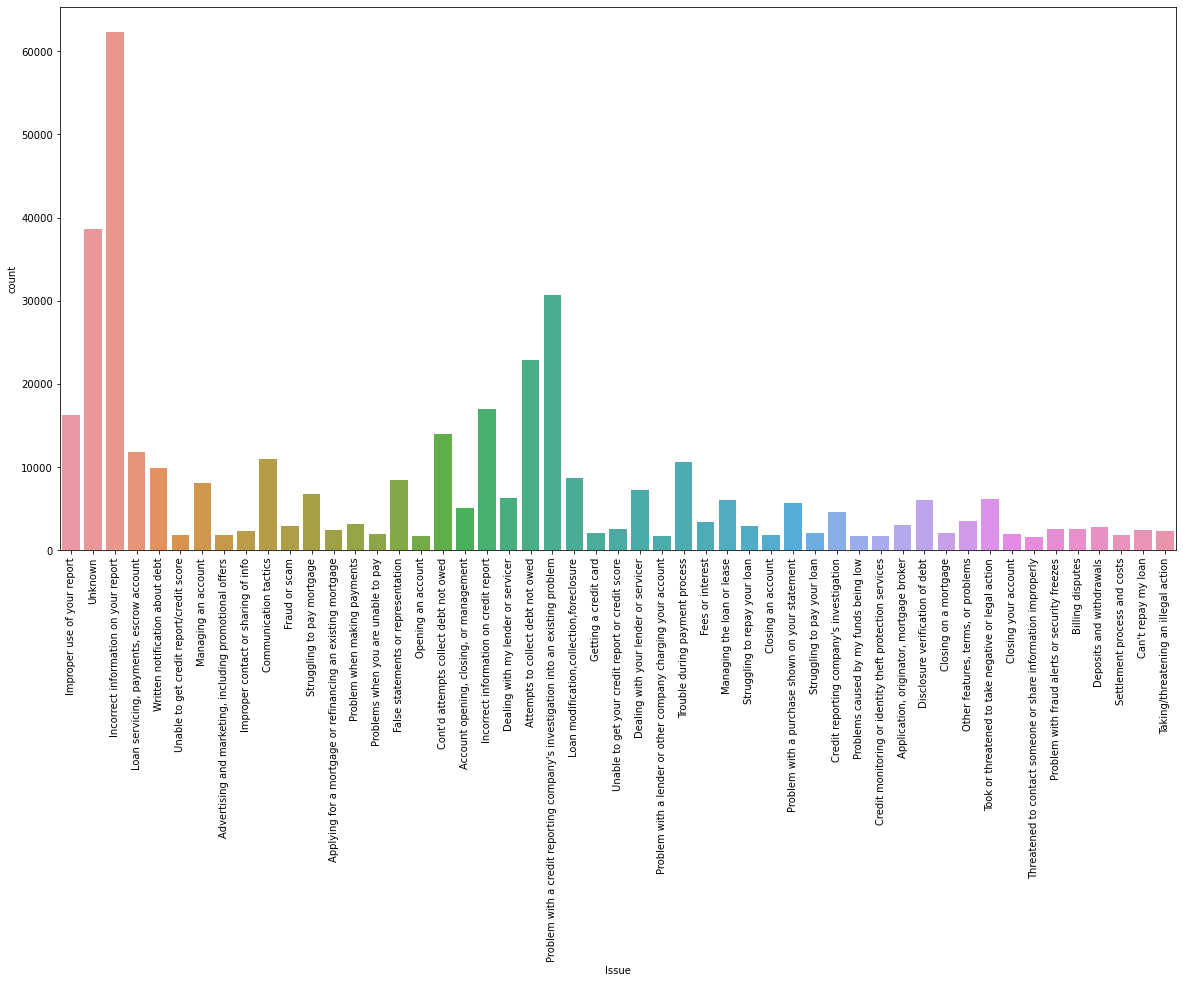

In [16]:
fig = plt.figure(figsize=(20,10))
chart = sns.countplot('Issue', data=train_data)
labels = chart.get_xticklabels()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

We decide to create two different sizes of balanced datasets so we could experiment with both. The balancing was realized by using sampling and in some cases oversampling.

In [17]:
# Define boundaries for sampling
BALANCE_SMALL_UPPER = 1000
BALANCE_SMALL_LOWER = 500
BALANCE_LARGER_UPPER = 7500
BALANCE_LARGER_LOWER = 5000

def create_balanced_dataset(df, lower, upper):

    balanced_data = pd.DataFrame()

    for issue in ISS_VOCAB:
        if df[df['Issue'] == issue].shape[0] > upper:
            # Sample when more available than upper boundary
            balanced_data = pd.concat([df[df['Issue'] == issue].sample(upper), balanced_data])
        if df[df['Issue'] == issue].shape[0] <= lower and df[df['Issue'] == issue].shape[0] > 0:
            # Oversample up to lower boundary when to few available
            balanced_data = pd.concat([df[df['Issue'] == issue].sample(lower, replace=True), balanced_data])

    return balanced_data

balanced_train_small = create_balanced_dataset(train_data, BALANCE_SMALL_LOWER, BALANCE_SMALL_UPPER)
balanced_train_larger = create_balanced_dataset(train_data, BALANCE_LARGER_LOWER, BALANCE_LARGER_UPPER)

The results of the balacing are the following: 

[Text(0, 0, 'Deposits and withdrawals'),
 Text(0, 0, 'Problems caused by my funds being low'),
 Text(0, 0, 'Improper contact or sharing of info'),
 Text(0, 0, 'Application, originator, mortgage broker'),
 Text(0, 0, 'Problems when you are unable to pay'),
 Text(0, 0, "Credit reporting company's investigation"),
 Text(0, 0, 'Unable to get credit report/credit score'),
 Text(0, 0, 'Dealing with my lender or servicer'),
 Text(0, 0, 'Billing disputes'),
 Text(0, 0, 'Incorrect information on credit report'),
 Text(0, 0, 'Account opening, closing, or management'),
 Text(0, 0, "Can't repay my loan"),
 Text(0, 0, 'Disclosure verification of debt'),
 Text(0, 0, "Cont'd attempts collect debt not owed"),
 Text(0, 0, 'Settlement process and costs'),
 Text(0, 0, 'Taking/threatening an illegal action'),
 Text(0, 0, 'Loan modification,collection,foreclosure'),
 Text(0, 0, 'Loan servicing, payments, escrow account'),
 Text(0, 0, 'Applying for a mortgage or refinancing an existing mortgage'),
 Text(0, 

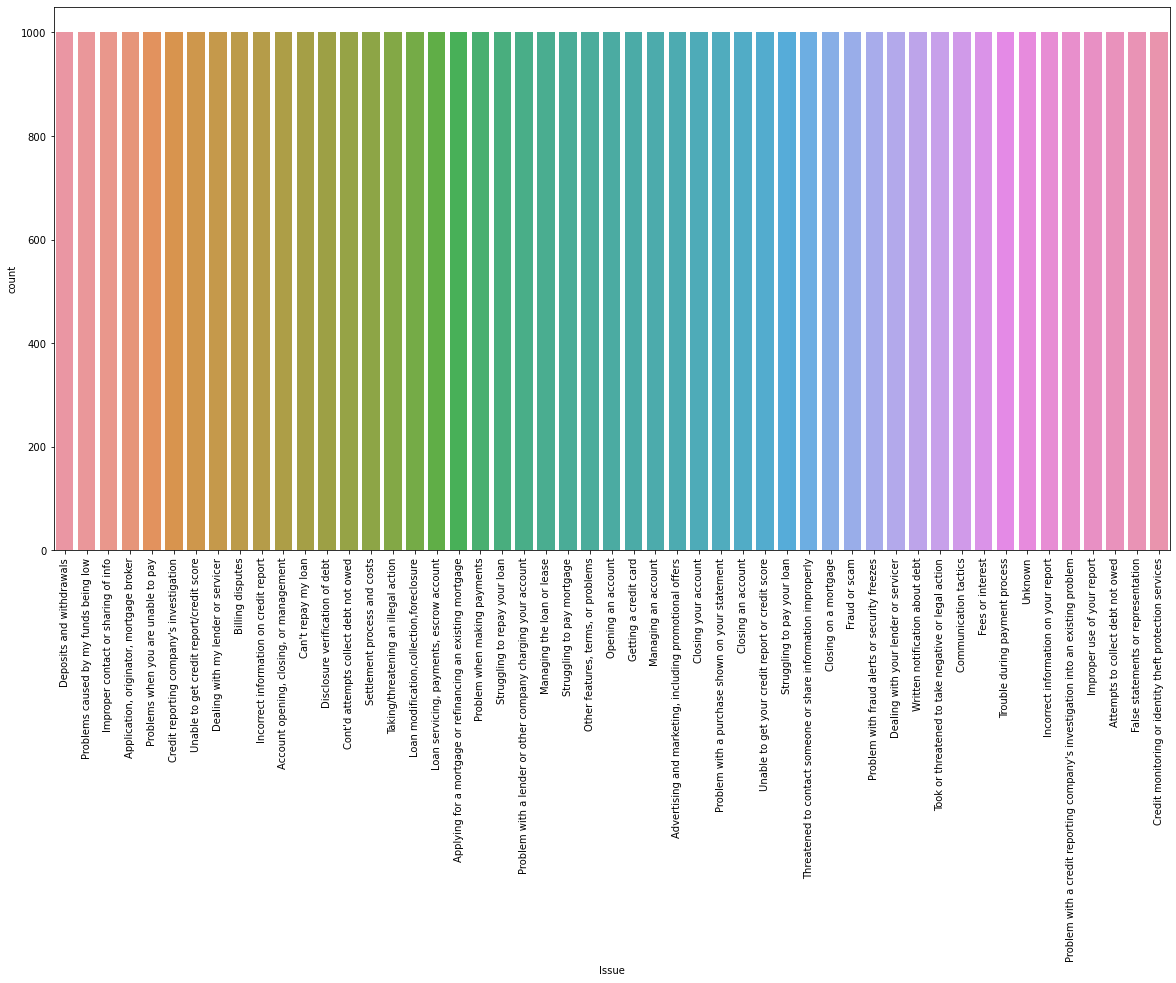

In [18]:
# Small balanced dataset
fig = plt.figure(figsize=(20,10))
chart = sns.countplot('Issue', data=balanced_train_small)
labels = chart.get_xticklabels()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

[Text(0, 0, 'Deposits and withdrawals'),
 Text(0, 0, 'Problems caused by my funds being low'),
 Text(0, 0, 'Improper contact or sharing of info'),
 Text(0, 0, 'Application, originator, mortgage broker'),
 Text(0, 0, 'Problems when you are unable to pay'),
 Text(0, 0, "Credit reporting company's investigation"),
 Text(0, 0, 'Unable to get credit report/credit score'),
 Text(0, 0, 'Billing disputes'),
 Text(0, 0, 'Incorrect information on credit report'),
 Text(0, 0, "Can't repay my loan"),
 Text(0, 0, "Cont'd attempts collect debt not owed"),
 Text(0, 0, 'Settlement process and costs'),
 Text(0, 0, 'Taking/threatening an illegal action'),
 Text(0, 0, 'Loan modification,collection,foreclosure'),
 Text(0, 0, 'Loan servicing, payments, escrow account'),
 Text(0, 0, 'Applying for a mortgage or refinancing an existing mortgage'),
 Text(0, 0, 'Problem when making payments'),
 Text(0, 0, 'Struggling to repay your loan'),
 Text(0, 0, 'Problem with a lender or other company charging your account

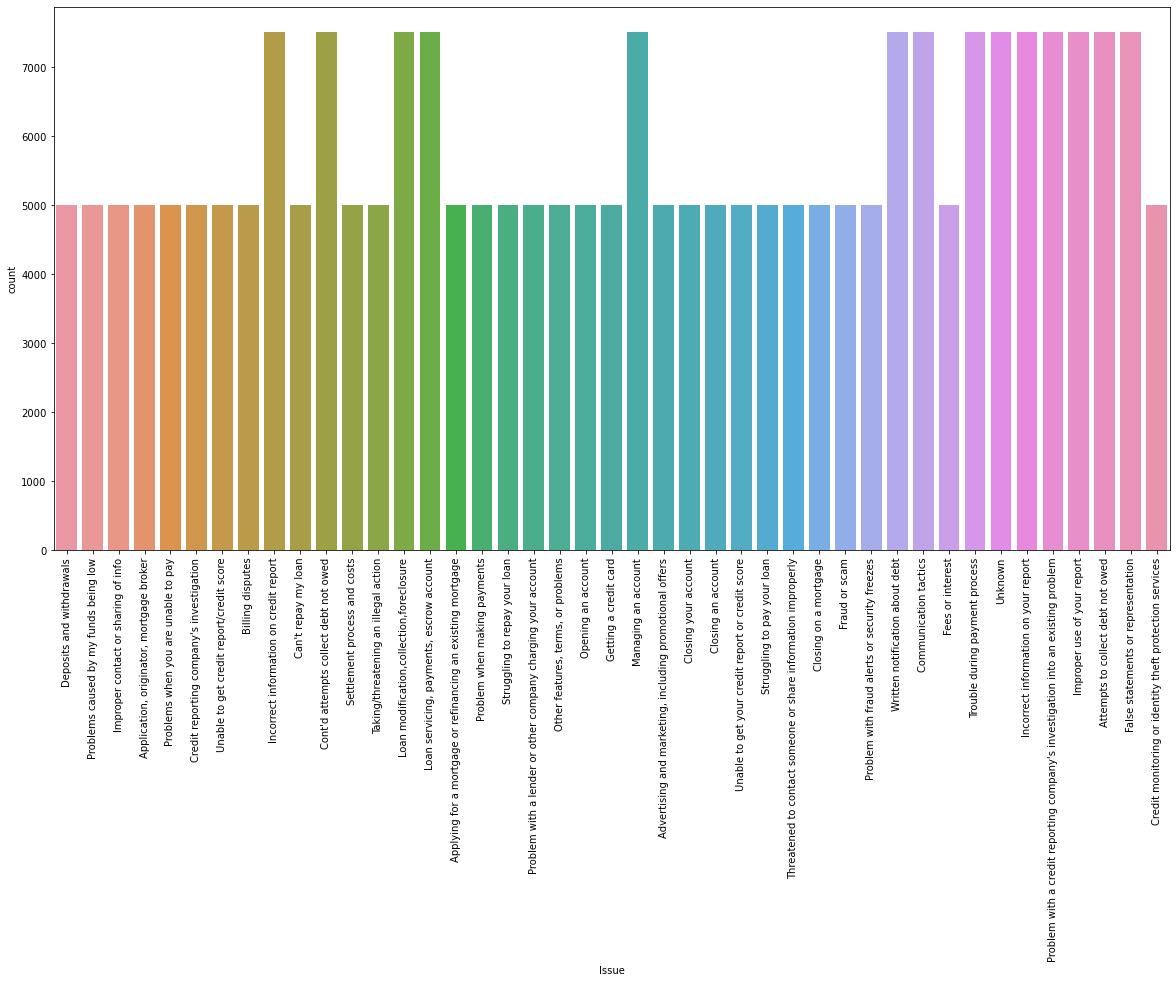

In [19]:
# Small balanced dataset
fig = plt.figure(figsize=(20,10))
chart = sns.countplot('Issue', data=balanced_train_larger)
labels = chart.get_xticklabels()
chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

### Storing the processed data

storing the processed data allowed us to skip the steps above when appropriate.

In [20]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [21]:
train_data.to_csv('./data/train_data.csv')
eval_data.to_csv('./data/eval_data.csv')
test_data.to_csv('./data/test_data.csv')
balanced_train_small.to_csv('./data/balanced_train_small.csv')
balanced_train_larger.to_csv('./data/balanced_train_larger.csv')

### Creating a Proof of Concept

Since we wanted to test our theory, we decided to create a Proof of Concept machine learning model before taking the steps to productionize the model. First we will analyze how well a basic NN performs with just the doc2vec model. Afterwards we add company names and products to see if the model gives better predictions. 

#### Sample dataset

In order to create a local model sampling is a good idea to minimize the load on our machines. 

In [38]:
subset = balanced_train_larger.sample(50000)


#### Feature extraction

We need to make the categorical columns and the textual column understandable for a machine. For the categorical columns we used one-hot-encoding. Previous sprints deterimend that Doc2Vec feature extraction works well, we decided to use this during Sprint 3 as well.

In [24]:
def one_hot_encode(df):
    comp_1he = pd.get_dummies(df['Company'])
    prod_1he = pd.get_dummies(df['Product'])
    targets_1he = pd.get_dummies(df['Issue'])

    return comp_1he, prod_1he, targets_1he

comp_1he, prod_1he, targets_1he = one_hot_encode(subset)

In [25]:
def doc2vec(df):
    listOfDocsAsListOfStrings = [doc for doc in (row.split() for row in df['Message'])]
    model = D2VTransformer(size=250, window=5, min_count=2, workers=multiprocessing.cpu_count())
    transformed = model.fit_transform(listOfDocsAsListOfStrings)
    return transformed

transformed = doc2vec(subset)

print(transformed.shape)
print(comp_1he.shape)
print(prod_1he.shape)

(40000, 250)
(40000, 2065)
(40000, 17)


#### Keras Model

Since NLP is usually preformed with neural networks we decided to try this approach as well. We used Keras to create a Proof of Concept model due to its ease of development.

The PoC keras model is very basic. It has two hidden layers, each having 256 nodes. The output shape is of course defined by the number of issues. The input shape depends on the data fed. There will be no hyperparameter tuning at all. A basic SGD will be used as our optimizer and categorical crossentropy will be used as the loss function. 

In [26]:
def createDataSets(x,y):
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.3)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.1)

    return x_train,x_val,x_test,y_train,y_val,y_test

In [27]:
def createModel(optimizer,loss, input_shape, output_shape):

    print(output_shape)
    
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(input_shape[1],)))
    model.add(Dense(256, activation='relu'))
    #model.add(Dense(256, activation='relu'))
    model.add(Dense(output_shape[1], activation='softmax'))
    
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    return model

In [28]:
def trainModel(model, x, y, batch_size=64, epochs=10):
    x_train,x_val,x_test,y_train,y_val,y_test = createDataSets(x,y)
    
    history = model.fit(x_train, y_train,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(x_val, y_val))
    return history, x_test,y_test

In [29]:
def validateModel(history, score):
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

The first model will only use the doc2vec data as input data. This will give us a base truth. Later on when adding new data, we can see if the added data helps improvve the model. If the model would perform worse afterwards, we should fall back to just using the doc2vec data.

In [30]:
y = targets_1he
x = transformed

(40000, 43)
Epoch 1/10
394/394 [==============================] - 1s 4ms/step - loss: 3.7099 - accuracy: 0.0543 - val_loss: 3.6256 - val_accuracy: 0.0871
Epoch 2/10
394/394 [==============================] - 1s 3ms/step - loss: 3.3701 - accuracy: 0.1292 - val_loss: 3.0756 - val_accuracy: 0.1471
Epoch 3/10
394/394 [==============================] - 1s 3ms/step - loss: 2.8300 - accuracy: 0.2133 - val_loss: 2.6834 - val_accuracy: 0.2264
Epoch 4/10
394/394 [==============================] - 1s 3ms/step - loss: 2.5539 - accuracy: 0.2638 - val_loss: 2.5125 - val_accuracy: 0.2518
Epoch 5/10
394/394 [==============================] - 1s 3ms/step - loss: 2.4209 - accuracy: 0.2901 - val_loss: 2.4215 - val_accuracy: 0.2804
Epoch 6/10
394/394 [==============================] - 1s 3ms/step - loss: 2.3368 - accuracy: 0.3133 - val_loss: 2.3747 - val_accuracy: 0.2836
Epoch 7/10
394/394 [==============================] - 1s 3ms/step - loss: 2.2805 - accuracy: 0.3254 - val_loss: 2.3408 - val_accuracy: 0

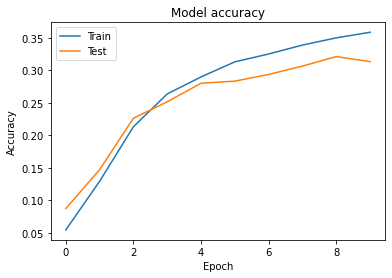

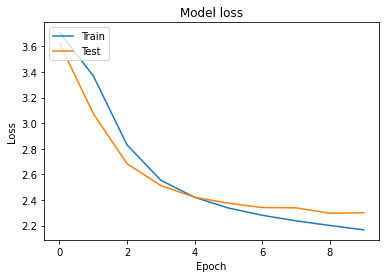

In [31]:
model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape, y.shape)

history, x_test,y_test = trainModel(model,x,y)

score = model.evaluate(x_test, y_test, verbose=0)
validateModel(history,score)

We get an accuracy of about 30+% when only using the dov2vec data with the NN. Let's see how much this improves by adding company names.

(40000, 43)
Epoch 1/10
394/394 [==============================] - 2s 5ms/step - loss: 3.6889 - accuracy: 0.0650 - val_loss: 3.5290 - val_accuracy: 0.1236
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 3.0449 - accuracy: 0.1596 - val_loss: 2.6565 - val_accuracy: 0.1879
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 2.4730 - accuracy: 0.2365 - val_loss: 2.3506 - val_accuracy: 0.2729
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 2.2528 - accuracy: 0.2903 - val_loss: 2.2030 - val_accuracy: 0.2971
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 2.1309 - accuracy: 0.3201 - val_loss: 2.1378 - val_accuracy: 0.3193
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 2.0480 - accuracy: 0.3472 - val_loss: 2.0821 - val_accuracy: 0.3232
Epoch 7/10
394/394 [==============================] - 2s 5ms/step - loss: 1.9883 - accuracy: 0.3633 - val_loss: 2.0413 - val_accuracy: 0

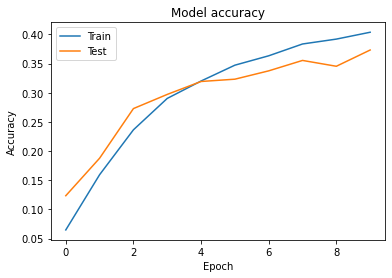

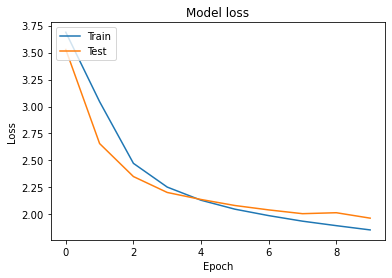

In [32]:
x = np.append(transformed, comp_1he.to_numpy(),axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

The basic keras NN improves with about 5% by adding company names. This is not as much as we expected since companies and certain issues seemed to be related, given a company's business model ect.

We will now check how good the model performs when adding product categories to the dov2vec model.

(40000, 43)
Epoch 1/10
394/394 [==============================] - 1s 3ms/step - loss: 2.7624 - accuracy: 0.2338 - val_loss: 1.7319 - val_accuracy: 0.3050
Epoch 2/10
394/394 [==============================] - 1s 3ms/step - loss: 1.6220 - accuracy: 0.3482 - val_loss: 1.5192 - val_accuracy: 0.3836
Epoch 3/10
394/394 [==============================] - 1s 3ms/step - loss: 1.4899 - accuracy: 0.4125 - val_loss: 1.4451 - val_accuracy: 0.4311
Epoch 4/10
394/394 [==============================] - 1s 3ms/step - loss: 1.4018 - accuracy: 0.4513 - val_loss: 1.3740 - val_accuracy: 0.4707
Epoch 5/10
394/394 [==============================] - 1s 3ms/step - loss: 1.3398 - accuracy: 0.4799 - val_loss: 1.3360 - val_accuracy: 0.4804
Epoch 6/10
394/394 [==============================] - 1s 3ms/step - loss: 1.3007 - accuracy: 0.4967 - val_loss: 1.3055 - val_accuracy: 0.4868
Epoch 7/10
394/394 [==============================] - 1s 3ms/step - loss: 1.2691 - accuracy: 0.5132 - val_loss: 1.3139 - val_accuracy: 0

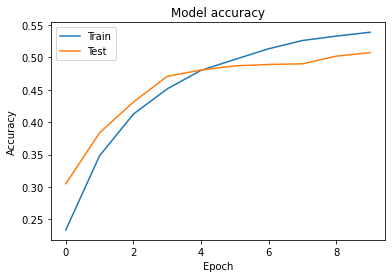

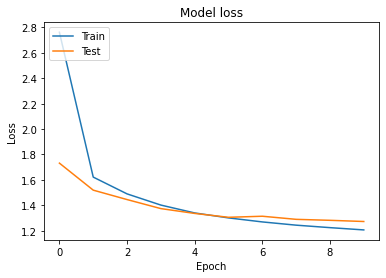

In [33]:
x = np.append(transformed, prod_1he.to_numpy(),axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

Adding products seems to give a way better performance. The model has about 50% accuracy now.

We wonder if the model now makes predictions solely on product and company, since it might be possible that those predict issues way better than the dov2vec model.


(40000, 43)
Epoch 1/10
394/394 [==============================] - 2s 5ms/step - loss: 2.9388 - accuracy: 0.2012 - val_loss: 1.8476 - val_accuracy: 0.2821
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 1.7255 - accuracy: 0.2817 - val_loss: 1.6647 - val_accuracy: 0.2918
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 1.6573 - accuracy: 0.2948 - val_loss: 1.6558 - val_accuracy: 0.3043
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 1.6372 - accuracy: 0.3013 - val_loss: 1.6378 - val_accuracy: 0.3046
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 1.6266 - accuracy: 0.3065 - val_loss: 1.6209 - val_accuracy: 0.2886
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 1.6154 - accuracy: 0.3059 - val_loss: 1.6102 - val_accuracy: 0.3200
Epoch 7/10
394/394 [==============================] - 2s 5ms/step - loss: 1.6072 - accuracy: 0.3162 - val_loss: 1.6128 - val_accuracy: 0

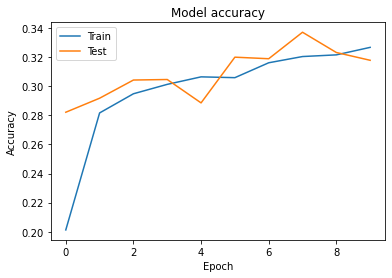

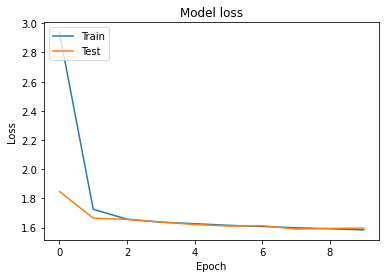

In [34]:
x = np.append(comp_1he.to_numpy(), prod_1he.to_numpy(),axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

We still get an accuracy of 30%.  The loss function only improves with very minor steps compared to before, this means there's just not enough meaningful data to train the model with anymore. Since the accuracy is 30% and the model can not be trained further, we conclude that  there's no way the model can tell exactly what issue it's going to be depending on company and product. It is clear that the doc2vec model is very much needed for better predictions. 


Lastly we check how the model performs when adding all the features:


(40000, 43)
Epoch 1/10
394/394 [==============================] - 2s 5ms/step - loss: 2.9427 - accuracy: 0.1923 - val_loss: 1.8479 - val_accuracy: 0.3007
Epoch 2/10
394/394 [==============================] - 2s 5ms/step - loss: 1.6661 - accuracy: 0.3335 - val_loss: 1.5973 - val_accuracy: 0.3596
Epoch 3/10
394/394 [==============================] - 2s 5ms/step - loss: 1.5163 - accuracy: 0.3958 - val_loss: 1.4971 - val_accuracy: 0.3986
Epoch 4/10
394/394 [==============================] - 2s 5ms/step - loss: 1.4171 - accuracy: 0.4411 - val_loss: 1.4283 - val_accuracy: 0.4225
Epoch 5/10
394/394 [==============================] - 2s 5ms/step - loss: 1.3463 - accuracy: 0.4753 - val_loss: 1.4032 - val_accuracy: 0.4443
Epoch 6/10
394/394 [==============================] - 2s 5ms/step - loss: 1.2974 - accuracy: 0.4985 - val_loss: 1.3735 - val_accuracy: 0.4675
Epoch 7/10
394/394 [==============================] - 2s 6ms/step - loss: 1.2612 - accuracy: 0.5150 - val_loss: 1.3659 - val_accuracy: 0

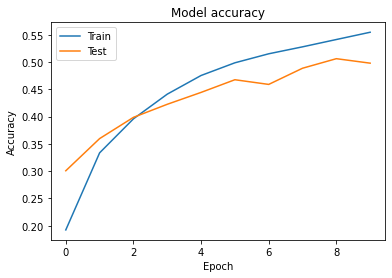

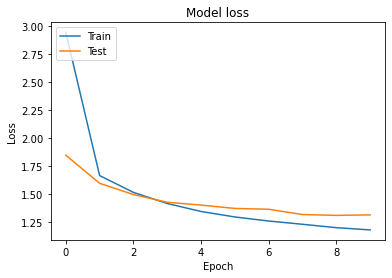

In [35]:
x = np.append(comp_1he.to_numpy(), prod_1he.to_numpy(),axis=1)
x = np.append(transformed, x, axis=1)

model = createModel(SGD(lr=0.01, momentum=0.9),CategoricalCrossentropy(),x.shape,y.shape)

history,x_test,y_test = trainModel(model,x,y)
score = model.evaluate(x_test, y_test, verbose=0)

validateModel(history,score)

#### Conclusions of PoC

At this point we are able to conclude the following:
- The model seems to work quite well. We get an accuracy of about 50% with a standard Keras model. It is worth to look further into this problem.
- We get the best performance using all chosen features. The company names are not as neccesary, it gives a marginal performance boost. However more data doesn't hurt

>**note**: Since we have a limited amount of time and we set ourselves an ambitious goal we will not focus that much on the accuracy of the model. We did this in previous sprints. During Sprint 3 we mainly want to complete the full end-to-end flow of machine learning.

## Making our solution available for actual users

As mentioned earlier, we will make use of the Google Cloud Platform in order to accomplish productionizing the model.

Our goal is that we can serve the prediction capabilities of our machine learning model trough an API endpoint. 

The following section describes the workflow we went through. However, not all code might be runnable since GCP requires authentication. The model however will be publicly addressable to show we actually accomplished our goal. 

### Tensorflow

In order to create a model that can be served on the GCP we will make use of the estimator API. The estimator API allows us to make use of canned estimators. We decided to use the canned estimators instead of creating our own estimator.

The estimator API takes away a lot of the complexity around productionizing a machine learning model. The concerns around distributed training etc. are handled for us. 

#### Creating feature columns

Feature columns define what types of features we will work with. (We experimented with feature crosses to make use of memorization. However this did not improve our model so we left it out in the end.)

In [ ]:
def get_feature_columns():
    return [
        # tf.feature_column.crossed_column(['Product', 'Company'], len(COMP_VOCAB) * len(PROD_VOCAB))
        # one hot encoding of the categorical product column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', PROD_VOCAB)),
        # one hot encoding of the categorical company column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', COMP_VOCAB)),
        # embedding of text using premade model 
        hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
    ]

> **Note**: We used a premade model for text embedding. Originally we wanted to use Doc2Vec like we did in the PoC but we did not know how.


#### Input functions

We need to define input functions so that our model uses the right data in the right situation. Also, an extra input function needs to be created that defines how the deployed model should handle input.

In [ ]:
def get_input_fn(tf_mode):

    if tf_mode == tf.estimator.ModeKeys.TRAIN:
        df = balanced_train_larger
        num_epochs = None
        shuffle = True
    else:
        if tf_mode == tf.estimator.ModeKeys.EVAL:
              df = eval_data
        else:
            df = test_data
        num_epochs = 1
        shuffle = False
  
    return tf.estimator.inputs.pandas_input_fn(
        x = df[CSV_FEATURES],
        y = df[TARGET_LABEL], 
        num_epochs = num_epochs, 
        batch_size = 512, 
        shuffle=shuffle
    )

In [ ]:
def get_serve_input_fn():

  # We'll receive 3 inputs, all of them are strings
    feat_placeholders = {
      'Product' : tf.placeholder(tf.string, [None]), 
      'Company' : tf.placeholder(tf.string, [None]), 
      'Message' : tf.placeholder(tf.string, [None])
    }

    features = feat_placeholders

    return tf.estimator.export.ServingInputReceiver(features, feat_placeholders)

#### Experimenting with different types of models 


Since canned estimators allow us to try different types of models relatively easy we decided to try three different models. 

##### Linear model 

The first model we tried was a Linear Classifier.

In [ ]:
# Train and evaluate with canned estimator
def train_and_evaluate_lin(model_dir, steps):

    tf.summary.FileWriterCache.clear()

    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100,
        #save_checkpoints_steps=100
    )

  # Create the estimator
    estimator = tf.estimator.LinearClassifier(
        config = run_config,
        feature_columns = get_feature_columns(), 
        n_classes = len(ISS_VOCAB),
        label_vocabulary=list(ISS_VOCAB)
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
        input_fn = get_input_fn(tf.estimator.ModeKeys.TRAIN),
        max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_input_fn(tf.estimator.ModeKeys.EVAL),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Lets train this model:

In [ ]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.INFO)
OUTDIR = 'linear_model'
shutil.rmtree(OUTDIR, ignore_errors=True)
train_and_evaluate_lin(OUTDIR, 2000)

Lets evaluate this model:

In [ ]:
estimator = tf.estimator.LinearClassifier(
    model_dir='linear_model',
    feature_columns = get_feature_columns(), 
    n_classes = len(ISS_VOCAB),
    label_vocabulary=list(ISS_VOCAB)
)

estimator.evaluate(get_input_fn(tf.estimator.ModeKeys.PREDICT))

This model achieves an accuracy of about 20% (a random model would be about 5%).

##### Deep Neural Network model 

The second model we tried was a Deep Neural Network Classifier with a similar construction to our PoC DNN.

In [ ]:
def train_and_evaluate_dnn(model_dir, steps):

    tf.summary.FileWriterCache.clear()

    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100,
        #save_checkpoints_steps=100
    )

  # Create the estimator
    estimator = tf.estimator.DNNClassifier(
        hidden_units = [256, 256], 
        feature_columns = get_feature_columns(), 
        config = run_config,
        n_classes= len(list(ISS_VOCAB)), 
        label_vocabulary=list(ISS_VOCAB), 
    )

  # Create exporter
      exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
         input_fn = get_input_fn(tf.estimator.ModeKeys.TRAIN),
         max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_input_fn(tf.estimator.ModeKeys.EVAL),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Lets train the model:

In [ ]:
OUTDIR = 'deep_neural_network'
shutil.rmtree(OUTDIR, ignore_errors=True) 
train_and_evaluate_dnn(OUTDIR, 2000)

Lets evaluate the model:

In [2]:
estimator = tf.estimator.DNNClassifier(
    hidden_units = [256, 256], 
    feature_columns = get_feature_columns(), 
    model_dir = OUTDIR, 
    n_classes= len(list(ISS_VOCAB)), 
    label_vocabulary=list(ISS_VOCAB), 
  )

estimator.evaluate(get_input_fn(tf.estimator.ModeKeys.PREDICT))

NameError: ignored

This model achieves an accuracy of about 10%. Because of the results in the Proof of Concept we anticipated a much better score. However, this is probably due to the fact that we don't use Doc2Vec here. 

##### Wide and Deep model 

We decided to try a third kind of model. A wide and deep model is a combination of a Linear type and DNN type model. It allows us to decide which features are better used in what kind of model.

In [ ]:
# Create wide features (for linear part of model):
def get_wide_features():
    return [
      # tf.feature_column.crossed_column(['Product', 'Company'], len(PROD_VOCAB) * len(COMP_VOCAB))
      # one hot encoding of the categorical product column (using vocab)
      tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', PROD_VOCAB)),
      # one hot encoding of the categorical company column (using vocab)
      tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', COMP_VOCAB))
    ]

# Create deep features (for DNN part of model):
def get_deep_features():
    return [
      # embedding of text using premade model 
      hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
  ]

In [ ]:
# Train and evaluate with canned estimator
def train_and_evaluate_wnd(model_dir, steps):

    tf.summary.FileWriterCache.clear()

  # Create the estimator
    estimator = tf.estimator.DNNLinearCombinedClassifier(
        model_dir=model_dir, 
        linear_feature_columns=get_wide_features(), 
        dnn_feature_columns=get_deep_features(),  
        dnn_hidden_units=[256,256],
        n_classes=len(list(ISS_VOCAB)), 
        label_vocabulary=list(ISS_VOCAB), 
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
        input_fn = get_input_fn(tf.estimator.ModeKeys.TRAIN),
        max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
        input_fn = get_input_fn(tf.estimator.ModeKeys.EVAL),
        exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Lets train the model:



In [ ]:
OUTDIR = 'wide_and_deep'
shutil.rmtree(OUTDIR, ignore_errors=True) 
train_and_evaluate_dnn(OUTDIR, 2000)

Lets evaluate the model:

In [ ]:
estimator = tf.estimator.DNNLinearCombinedClassifier(
    model_dir=OUTDIR, 
    linear_feature_columns=get_wide_features(), 
    dnn_feature_columns=get_deep_features(),  
    dnn_hidden_units=[256,256],
    n_classes=len(list(ISS_VOCAB)), 
    label_vocabulary=list(ISS_VOCAB), 
  )
estimator.evaluate(get_input_fn(tf.estimator.ModeKeys.PREDICT))

### Packaging the code

In order to train the model on GCP, which allows for hyperparameter tuning, we need to create a package. This requires the creation of 3 files.

#### `__init__.py`


In [ ]:
!mkdir trainer

In [121]:
%%writefile trainer/__init__.py

# empty

Writing trainer/__init__.py


#### model.py

This file defines the model that will be used

In [41]:
%%writefile trainer/model.py

import sys
import os 

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from nltk.stem.snowball import SnowballStemmer

import multiprocessing
from gensim.sklearn_api import D2VTransformer

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
import shutil

PROJECT = 'appliedml-270208'
BUCKET = 'applied_machine_learning_bucket'
REGION = 'europe-west1'

# Define constants (relevant columns, the target and default values for blank fields)
CSV_COLUMNS = ['Product', 'Company', 'Message', 'Issue']
CSV_FEATURES = ['Product', 'Company', 'Message']
TARGET_LABEL = 'Issue'
DEFAULTS = [['Unknown'], ['Unknown'], ['Unknown']]

NNSIZE = None
BATCH_SIZE = 512

TRAIN_PATH = None
EVAL_PATH = None
TEST_PATH = None

PROD_VOCAB = None
COMP_VOCAB = None
ISS_VOCAB = None


def get_feature_columns(prods, comps):
    return [
        # tf.feature_column.crossed_column(['Product', 'Company'], len(COMP_VOCAB) * len(PROD_VOCAB))
        # one hot encoding of the categorical product column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', prods)),
        # one hot encoding of the categorical company column (using vocab)
        tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', comps)),
        # embedding of text using premade model 
        hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
    ]

def get_input_fn(df, tf_mode):

    if tf_mode == tf.estimator.ModeKeys.TRAIN:
        num_epochs = None
        shuffle = True
    else:
        num_epochs = 1
        shuffle = False
  
    return tf.estimator.inputs.pandas_input_fn(
        x = df[CSV_FEATURES],
        y = df[TARGET_LABEL], 
        num_epochs = num_epochs, 
        batch_size = BATCH_SIZE, 
        shuffle=shuffle
    )

def get_serve_input_fn():

  # We'll receive 3 inputs, all of them are strings
    feat_placeholders = {
      'Product' : tf.placeholder(tf.string, [None]), 
      'Company' : tf.placeholder(tf.string, [None]), 
      'Message' : tf.placeholder(tf.string, [None])
    }

    features = feat_placeholders

    return tf.estimator.export.ServingInputReceiver(features, feat_placeholders)

# Train and evaluate with canned estimator
def train_and_evaluate_lin(model_dir, steps):

    tf.summary.FileWriterCache.clear()

    train_data = pd.read_csv(TRAIN_PATH)
    eval_data = pd.read_csv(EVAL_PATH)
    test_data = pd.read_csv(TEST_PATH)

    PROD_VOCAB = np.append(train_data['Product'].unique(), 'Unknown')
    PROD_VOCAB = np.append(PROD_VOCAB, eval_data['Product'].unique())
    PROD_VOCAB = np.append(PROD_VOCAB, test_data['Product'].unique())
    PROD_VOCAB = list(set(PROD_VOCAB))

    COMP_VOCAB = np.append(train_data['Company'].unique(), 'Unknown')
    COMP_VOCAB = np.append(COMP_VOCAB, eval_data['Company'].unique())
    COMP_VOCAB = np.append(COMP_VOCAB, test_data['Company'].unique())
    COMP_VOCAB = list(set(COMP_VOCAB))

    ISS_VOCAB = np.append(train_data['Issue'].unique(), 'Unknown')
    ISS_VOCAB = np.append(ISS_VOCAB, eval_data['Issue'].unique())
    ISS_VOCAB = np.append(ISS_VOCAB, test_data['Issue'].unique())
    ISS_VOCAB = list(set(ISS_VOCAB))

    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100,
        #save_checkpoints_steps=100
    )

  # Create the estimator
    estimator = tf.estimator.LinearClassifier(
        config = run_config,
        feature_columns = get_feature_columns(PROD_VOCAB, COMP_VOCAB), 
        n_classes = len(ISS_VOCAB),
        label_vocabulary=list(ISS_VOCAB)
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
         input_fn = get_input_fn(test_data, tf.estimator.ModeKeys.TRAIN),
         max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
      input_fn = get_input_fn(eval_data, tf.estimator.ModeKeys.EVAL),
      exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

def train_and_evaluate_dnn(model_dir, steps):

    tf.summary.FileWriterCache.clear()

    train_data = pd.read_csv(TRAIN_PATH)
    eval_data = pd.read_csv(EVAL_PATH)
    test_data = pd.read_csv(TEST_PATH)

    PROD_VOCAB = np.append(train_data['Product'].unique(), 'Unknown')
    PROD_VOCAB = np.append(PROD_VOCAB, eval_data['Product'].unique())
    PROD_VOCAB = np.append(PROD_VOCAB, test_data['Product'].unique())
    PROD_VOCAB = list(set(PROD_VOCAB))

    COMP_VOCAB = np.append(train_data['Company'].unique(), 'Unknown')
    COMP_VOCAB = np.append(COMP_VOCAB, eval_data['Company'].unique())
    COMP_VOCAB = np.append(COMP_VOCAB, test_data['Company'].unique())
    COMP_VOCAB = list(set(COMP_VOCAB))

    ISS_VOCAB = np.append(train_data['Issue'].unique(), 'Unknown')
    ISS_VOCAB = np.append(ISS_VOCAB, eval_data['Issue'].unique())
    ISS_VOCAB = np.append(ISS_VOCAB, test_data['Issue'].unique())
    ISS_VOCAB = list(set(ISS_VOCAB))

    run_config = tf.estimator.RunConfig(
        model_dir = model_dir, 
        #save_summary_steps=100,
        #save_checkpoints_steps=100
    )

  # Create the estimator
    estimator = tf.estimator.DNNClassifier(
        hidden_units = NNSIZE, 
        feature_columns = get_feature_columns(PROD_VOCAB, COMP_VOCAB), 
        config = run_config,
        n_classes= len(list(ISS_VOCAB)), 
        label_vocabulary=list(ISS_VOCAB), 
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
     input_fn = get_input_fn(train_data, tf.estimator.ModeKeys.TRAIN),
     max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
      input_fn = get_input_fn(eval_data, tf.estimator.ModeKeys.EVAL),
      exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

# Create wide features (for linear part of model):
def get_wide_features(prods, comps):
    return [
      # tf.feature_column.crossed_column(['Product', 'Company'], len(PROD_VOCAB) * len(COMP_VOCAB))
      # one hot encoding of the categorical product column (using vocab)
      tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Product', prods)),
      # one hot encoding of the categorical company column (using vocab)
      tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('Company', comps))
    ]

# Create deep features (for DNN part of model):
def get_deep_features():
    return [
      # embedding of text using premade model 
      hub.text_embedding_column('Message', module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")
  ]

# Train and evaluate with canned estimator
def train_and_evaluate_wnd(model_dir, steps):

    tf.summary.FileWriterCache.clear()

    train_data = pd.read_csv(TRAIN_PATH)
    eval_data = pd.read_csv(EVAL_PATH)
    test_data = pd.read_csv(TEST_PATH)

    PROD_VOCAB = np.append(train_data['Product'].unique(), 'Unknown')
    PROD_VOCAB = np.append(PROD_VOCAB, eval_data['Product'].unique())
    PROD_VOCAB = np.append(PROD_VOCAB, test_data['Product'].unique())
    PROD_VOCAB = list(set(PROD_VOCAB))

    COMP_VOCAB = np.append(train_data['Company'].unique(), 'Unknown')
    COMP_VOCAB = np.append(COMP_VOCAB, eval_data['Company'].unique())
    COMP_VOCAB = np.append(COMP_VOCAB, test_data['Company'].unique())
    COMP_VOCAB = list(set(COMP_VOCAB))

    ISS_VOCAB = np.append(train_data['Issue'].unique(), 'Unknown')
    ISS_VOCAB = np.append(ISS_VOCAB, eval_data['Issue'].unique())
    ISS_VOCAB = np.append(ISS_VOCAB, test_data['Issue'].unique())
    ISS_VOCAB = list(set(ISS_VOCAB))

  # Create the estimator
    estimator = tf.estimator.DNNLinearCombinedClassifier(
        model_dir=model_dir, 
        linear_feature_columns=get_wide_features(PROD_VOCABS, COMP_VOCAB), 
        dnn_feature_columns=get_deep_features(),  
        dnn_hidden_units=NNSIZE,
        n_classes=len(list(ISS_VOCAB)), 
        label_vocabulary=list(ISS_VOCAB), 
        optimizer = tf.train.AdamOptimizer(learning_rate=0.01)
    )

  # Create exporter
    exporter = tf.estimator.LatestExporter('exporter', get_serve_input_fn)

  # Define the training specifications
    train_spec = tf.estimator.TrainSpec(
     input_fn = get_input_fn(train_data, tf.estimator.ModeKeys.TRAIN),
     max_steps = steps
    )

  # Define the evaluatin specifications
    eval_spec = tf.estimator.EvalSpec(
      input_fn = get_input_fn(eval_data, tf.estimator.ModeKeys.EVAL),
      exporters = exporter
    )

  # Call the actual train and evaluate function 
    tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

Overwriting trainer/model.py


#### trainer.py

This file parses the arguments and starts the specified task.

In [31]:
%%writefile trainer/task.py

import argparse
import json
import os

from . import model

if __name__ == '__main__':
  
  parser = argparse.ArgumentParser()

    parser.add_argument(
      '--model_dir',
      help = "Output folder for the model",
      required = True
    )
    parser.add_argument(
      '--train_steps',
      help = 'Amount of training steps',
      type = int,
      default = 2000
    )
    parser.add_argument(
      '--model_type',
      help = 'Type of model: linear, dnn or wnd',
      required = True
    )
    parser.add_argument(
      '--nnsize',
      help = 'Hidden layer sizes to use for DNN feature columns -- provide space-separated layers',
      nargs = '+',
      type = int,
      default=[256, 256]
    )
    parser.add_argument(
      '--train_data',
      help = 'Path of training data.',
      required=True
    )
    parser.add_argument(
      '--eval_data',
      help = 'Path of eval data.',
      required=True
    )
    parser.add_argument(
      '--test_data',
      help = 'Path of test data.',
      required=True
    )
    parser.add_argument(
      '--batch_size',
      help = 'The size of the batches.',
      type = int,
      default=512
    )

    args = parser.parse_args()
    arguments = args.__dict__

    arguments.pop('job_dir', None)
    arguments.pop('job-dir', None)

    output_dir = arguments.pop('model_dir')
    steps = arguments.pop('train_steps')
    model_type = arguments.pop('model_type')
    model.NNSIZE = arguments.pop('nnsize')
    model.BATCH_SIZE = arguments.pop('batch_size')
    model.TRAIN_PATH = arguments.pop('train_data')
    model.EVAL_PATH = arguments.pop('eval_data')
    model.TEST_PATH = arguments.pop('test_data')

    output_dir = os.path.join(
    output_dir, 
    json.loads(
        os.environ.get('TF_CONFIG', '{}')
    ).get('task', {}).get('trail', '')
    )

    if model_type == 'linear':
        model.train_and_evaluate_lin(output_dir, steps)
    elif model_type == 'dnn':
        model.train_and_evaluate_dnn(output_dir, steps)
    else:
        model.train_and_evaluate_wnd(output_dir, steps)

Overwriting trainer/task.py


We executed the module locally to check if everything works properly:

In [1]:
%%bash
python -m trainer.task \
  --model_dir=trained \ 
  --train_steps=1 \
  --model_type=linear \
  --train_data=/content/data/balanced_train_larger.csv \
  --eval_data=/content/data/eval_data.csv \
  --test_data=/content/data/test_data.csv 

Process is terminated.


### Hyperparameter tuning

GCP allows for easy and optimized hyperparameter tuning. We didn't want to focus on the accuracy of the model. 

However, we wanted to try this because we wanted to know how to do it for future reference.

>** **bold text**note**: In the end we only documented how to do this. Because of the cost we opted not to execute the tuning.

The first thing we needed to was to create a yaml file containing all possible options:

In [4]:
%%writefile trainer/tune.yaml

trainingInput:
    scaleTier: STANDARD_1
    hyperparameters:
        hyperparameterMetricTag: # You need to define this
        goal: MINIMIZE
        maxTrials: 20
        maxParallelTrials: 5
        enableTrialEarlyStopping: True
        params:
        - parameterName: batch_size
          type: INTEGER
          minValue: 8
          maxValue: 512
          scaleType: UNIT_LOG_SCALE
        - parameterName: model_type
          type: DISCRETE 
          discreteValues:
          - linear
          - dnn
          - wnd
        - parameterName: nnsize
          type: INTEGER
          minValue: 64
          maxValue: 512
          scaleType: UNIT_LOG_SCALE

Writing trainer/tune.yaml


This command should run the hyperparameter tuning for us:

In [ ]:
gcloud ai-platform jobs submit training hype_training \
  --region=$REGION \
  --module-name=trainer.task \
  --package-path=. \
  --job-dir=trained \
  --staging-bucket=gs://$BUCKET \
  --scale-tier=STANDARD_1 \
  --config=tune.yaml \
  --runtime-version=$TFVERSION \
  -- \
  --model_dir=trained \
  --train_data=/content/data/balanced_train_larger.csv \
  --eval_data=/content/data/eval_data.csv \
  --test_data=/content/data/test_data.csv 

### Deploying the trained model

Since we trained locally already there is no need to train again. We'll deploy the linear model since it was the best of 3.

We first need to upload the trained model to GC Storage.

In [ ]:
%%bash
FOLDER=$(ls linear_model/export/exporter)
echo ${FOLDER}
gsutil -m cp -R /content/linear_model/export/exporter/${FOLDER} gs://${BUCKET}/trained

In [64]:
!gsutil ls gs://$BUCKET/trained

gs://applied_machine_learning_bucket/trained/saved_model.pb
gs://applied_machine_learning_bucket/trained/assets/
gs://applied_machine_learning_bucket/trained/variables/


In [65]:
!gcloud ai-platform models create sprint3

ERROR: (gcloud.ai-platform.models.create) You do not currently have an active account selected.
Please run:

  $ gcloud auth login

to obtain new credentials, or if you have already logged in with a
different account:

  $ gcloud config set account ACCOUNT

to select an already authenticated account to use.


In [67]:
!gcloud auth login

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?code_challenge=l8XmgQ3Z6YvPpqo4YdyKK_jWS8VKNE97BiUYYa066Go&prompt=select_account&code_challenge_method=S256&access_type=offline&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&client_id=32555940559.apps.googleusercontent.com&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth


Enter verification code: 4/0AGwpxAoTzexjFrRFkrp5rfjKjUb4UAEUmkp7BsAdp9MsuAuaEaqDvU

You are now logged in as [desmettim@outlook.com].
Your current project is [appliedml-270208].  You can change this setting by running:
  $ gcloud config set project PROJECT_ID


In [68]:
!gcloud ai-platform versions create final  --model sprint3 --origin gs://$BUCKET/trained --runtime-version 1.15 --framework tensorflow

### Making predictions

Now we need to test if we can actually make predictions using our deployed model:

In [72]:
# Use test data:
test_data = pd.read_csv('/content/data/test_data.csv')
print(test_data.iloc[0])

Unnamed: 0                                               127009
Product                                   Vehicle loan or lease
Company                           CREDIT ACCEPTANCE CORPORATION
Message       car purchas payment month call compani make ar...
Issue                               Struggling to pay your loan
Name: 0, dtype: object


In [74]:
%%writefile test.json
{"Product":"Vehicle loan or lease","Company":"CREDIT ACCEPTANCE CORPORATION","Message":"car purchas payment month call compani make arrang pay month rep state day work u said later month respons problem start call state made arrang pay told problem rep phone said one told problem month pay car made payment call say pass due late fee take car state never told late fee rep said problem said pay next payment due hard time said well continu call u said call time day hung"}

Writing test.json


In [1]:
!gcloud ai-platform predict --model=sprint3 --json-instances=test.json

ALL_CLASS_IDS                                                                                                                                                                                       ALL_CLASSES                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

We get the following answer:

**all class ids**:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]  

**all class names**:
[u'Credit monitoring or identity theft protection services', u'False statements or representation', u'Attempts to collect debt not owed', u'Improper use of your report', u"Problem with a credit reporting company's investigation into an existing problem", u'Incorrect information on your report', u'Unknown', u'Trouble during payment process', u'Fees or interest', u'Communication tactics', u'Took or threatened to take negative or legal action', u'Written notification about debt', u'Dealing with your lender or servicer', u'Problem with fraud alerts or security freezes', u'Fraud or scam', u'Closing on a mortgage', u'Threatened to contact someone or share information improperly', u'Struggling to pay your loan', u'Unable to get your credit report or credit score', u'Closing an account', u'Problem with a purchase shown on your statement', u'Closing your account', u'Advertising and marketing, including promotional offers', u'Managing an account', u'Getting a credit card', u'Opening an account', u'Other features, terms, or problems', u'Struggling to pay mortgage', u'Managing the loan or lease', u'Problem with a lender or other company charging your account', u'Struggling to repay your loan', u'Problem when making payments', u'Applying for a mortgage or refinancing an existing mortgage', u'Loan servicing, payments, escrow account', u'Loan modification,collection,foreclosure', u'Taking/threatening an illegal action', u'Settlement process and costs', u"Cont'd attempts collect debt not owed", u'Disclosure verification of debt', u"Can't repay my loan", u'Account opening, closing, or management', u'Incorrect information on credit report', u'Billing disputes', u'Dealing with my lender or servicer', u'Unable to get credit report/credit score', u"Credit reporting company's investigation", u'Problems when you are unable to pay', u'Application, originator, mortgage broker', u'Improper contact or sharing of info', u'Problems caused by my funds being low', u'Deposits and withdrawals'] 


**chosen class id**: [17]       


**chosen class**: [u'Struggling to pay your loan']  

**logits**:
[-2.0418670177459717, -16.874784469604492, -9.737305641174316, -7.570767879486084, -5.339376926422119, -5.096161365509033, -4.203519821166992, -6.723516464233398, -6.306142330169678, -7.633228778839111, -16.874784469604492, -16.874784469604492, -16.874784469604492, -7.850489139556885, -8.056821823120117, -9.85521411895752, -8.225409507751465, -1.017134666442871, -10.442292213439941, -8.277178764343262, -16.874784469604492, -8.440375328063965, -7.760432720184326, -16.874784469604492, -9.989632606506348, -10.289300918579102, -7.3494768142700195, -16.874784469604492, -16.874784469604492, -7.328330993652344, -8.548629760742188, -6.064115047454834, -10.25114631652832, -3.9535467624664307, -16.874784469604492, -5.590899467468262, -8.161460876464844, -7.742534637451172, -16.874784469604492, -4.920774936676025, -16.874784469604492, -7.966688632965088, -5.45908260345459, -16.874784469604492, -9.322630882263184, -9.244152069091797, -2.489431142807007, -9.500584602355957, -8.012287139892578, -6.850594520568848, -7.723545551300049] 


**probabilities**:
[0.20033806562423706, 7.242847033239741e-08, 9.113327541854233e-05, 0.0007954124012030661, 0.007407525088638067, 0.00944713968783617, 0.023065859451889992, 0.001855876063928008, 0.0028171648737043142, 0.0007472499855794013, 7.242847033239741e-08, 7.242847033239741e-08, 7.242847033239741e-08, 0.0006013273377902806, 0.0004892172873951495, 8.09971897979267e-05, 0.00041331874672323465, 0.5582119226455688, 4.5030337787466124e-05, 0.0003924659686163068, 7.242847033239741e-08, 0.0003333701170049608, 0.0006579940090887249, 7.242847033239741e-08, 7.080970681272447e-05, 5.2474522817647085e-05, 0.00099242536816746, 7.242847033239741e-08, 7.242847033239741e-08, 0.0010136344935745, 0.00029916607309132814, 0.0035885863471776247, 5.451534889289178e-05, 0.029616352170705795, 7.242847033239741e-08, 0.005760209634900093, 0.0004406133375596255, 0.0006698769284412265, 7.242847033239741e-08, 0.011258219368755817, 7.242847033239741e-08, 0.0005353603046387434, 0.006571819540113211, 7.242847033239741e-08, 0.00013796468556392938, 0.00014922817354090512, 0.1280527412891388, 0.00011547384201548994, 0.0005114969098940492, 0.001634404994547367, 0.0006827187607996166]


We were able to create a machine learning model and host it for predictions.